## Introduction

Name  : Ari Riscahyo Nugroho

Batch : 007

Github: Ari2109

This notebook contains Cyberbullying Tweet dataset from *J. Wang, K. Fu, C.T. Lu, “SOSNet: A Graph Convolutional Network Approach to Fine-Grained Cyberbullying Detection,” Proceedings of the 2020 IEEE International Conference on Big Data (IEEE BigData 2020), December 10-13, 2020*, available on https://www.kaggle.com/andrewmvd/cyberbullying-classification 

***TRIGGER WARNING!*** This notebook contains **offensive words regarding to age, gender, religion, ethnicity.** There might also be words containing **sexual harrassment.**

***PROCEED AT YOUR OWN RISK*** 

Before we continue, here are some notes regarding the dataset:

The author of the paper **used semi-supervised learning to generate and label some of the data in this dataset.** The goal for the paper is to **combat imbalanced dataset problems** occurring in NLP research. As such, **you might find incorrectly labeled data even in the original dataset**

**Humans' judgment are not bias-free. AI was built using input from humans' data.** **AI has limited capability**

Any seemingly incorrect labeled data could be caused from the AI failure to classify, creators' bias, readers' bias, or all of them. 


## Import Library

In [124]:
#!pip install langdetect

In [125]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import re
import nltk
from nltk.tokenize.casual import TweetTokenizer
from nltk.probability import FreqDist
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Embedding, LSTM, Dense, GRU
from tensorflow.keras.models import Sequential

### Download Required NLTK Package

In [126]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

## Data Load and EDA

In [127]:
pd.set_option('display.max_colwidth', None)

In [128]:
df = pd.read_csv("https://raw.githubusercontent.com/Ari2109/data_repo/main/cyberbullying_tweets.csv")

In [129]:
df.sample(10)

,tweet_text,cyberbullying_type
9869,"@Antifeminazi1 especially u being a woman debunking the feminazi's crock of bull, and your clear perception on equal rights",gender
45800,I can't believe that fuck ass white boy called me a dumb nigger over some shit I said about Joe Pa! GTFOH! it's not that serious!!,ethnicity
19136,"Obama underestimated ISIS, he also didn’t take them down. Terrorists could still come in you idiot. Doesn’t matter if they check his background, they can still get through. Keep defending ISIS, you will go far in life. He never grouped Muslims with ISIS.",religion
24120,the mage keeps trying to duel me,other_cyberbullying
43629,"@sashmorky *turns into a disgusting piece of shit* ""Well, there's black people, and then there's niggers...""",ethnicity
20630,@rico_hands @NAInfidels @semzyxx @owais00 Who cares. Jews don't marry children. Muslims do. All the time.,religion
15716,"It’s because, from personal experience, “females” has been the replacement for “bitches” by the shitty men who’ve been asked not to call me/us that so they essentially ruined the word for any respectful man bc now all we hear is the shitty connotation it now has.",gender
44579,@flanzamakhadanc I didnt fuckin break ur cord u dumb fuckin nigger. Fuck u ill buy ur bitch ass another cord Idgaf u beatoff. #scumthisdick,ethnicity
27455,@sjh_canada SHUT UP,other_cyberbullying
13016,Rape jokes aren't funny. Gay jokes aren't funny. Holocaust jokes aren't funny. Stop.,gender


We'll check the what are the classes provided in this dataset

In [130]:
df['cyberbullying_type'].unique()

array(['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying',
       'age', 'ethnicity'], dtype=object)

We'll check if there's any null data in the dataset

In [131]:
df.isnull().sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

Seems like there isn't. Let's go to do some data cleaning

## Data Cleaning

We'll do with one sample text to make clear of what did we do to clean

### Sample Text Cleaning

In [132]:
sample_text = df.loc[3]['tweet_text']
print(sample_text)

@Jason_Gio meh. :P  thanks for the heads up, but not too concerned about another angry dude on twitter.


As this is twitter, we'll remove the @username. But we'll try to preserve the emoji/emoticon

In [133]:
#deleting @'username' and punctuation, but keeping the emoji / emoticon 
sample_text = re.sub('@[^\s]+','',sample_text)
sample_text = re.sub('(?<=\w)[^\s\w](?![^\s\w])', '', sample_text)
print(sample_text)

 meh :P  thanks for the heads up but not too concerned about another angry dude on twitter


We'll use TweetTokenizer to ensure that the emoticon stayed intact

In [134]:
#word tokenizer, twitter style (keeping the emoticon in one place)
t = TweetTokenizer()
word_token = t.tokenize(sample_text)
print(word_token)

['meh', ':P', 'thanks', 'for', 'the', 'heads', 'up', 'but', 'not', 'too', 'concerned', 'about', 'another', 'angry', 'dude', 'on', 'twitter']


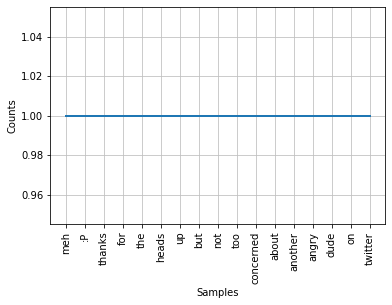

In [135]:
fdist = FreqDist(word_token)
fdist.plot(30, cumulative=False)
plt.show()

Note that the author of the paper does *not* clean the stopword because the author believed that the stopwords might contain more pattern regarding to cyberbullying. As such, we also not do stopword-cleaning

We'll try to do Stemming and Lemmatization-with-POS here. We'll only use one of them in the end later

In [136]:
# Lexicon Normalization
# Stemming

ps = PorterStemmer()

stemmed_words = []
for w in word_token:
    stemmed_words.append(ps.stem(w))

print("Filtered Sentence:", word_token)
print("Stemmed Sentence:", stemmed_words)

Filtered Sentence: ['meh', ':P', 'thanks', 'for', 'the', 'heads', 'up', 'but', 'not', 'too', 'concerned', 'about', 'another', 'angry', 'dude', 'on', 'twitter']
Stemmed Sentence: ['meh', ':P', 'thank', 'for', 'the', 'head', 'up', 'but', 'not', 'too', 'concern', 'about', 'anoth', 'angri', 'dude', 'on', 'twitter']


In [137]:
# Lemmatization with POS

lem = WordNetLemmatizer()
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    lem.lemmatize(word,)
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize_pos(tokenized_text):
    lemmatized = []
    for word in tokenized_text:
      lemmatized.append(lem.lemmatize(word, pos=get_wordnet_pos(word)))
    return lemmatized

lemmatized_token = lemmatize_pos(word_token)

def join_lemmatize_sentence(lemmatized_token):
  lemmatized_sentence = ""
  for x in lemmatized_token:
    lemmatized_sentence = lemmatized_sentence + " " + x
  lemmatized_sentence = lemmatized_sentence.strip()
  return lemmatized_sentence

join_lemmatize_sentence(lemmatized_token)
#print("Lemmatized with POS:", [lem.lemmatize(w, pos=get_wordnet_pos(w)) for w in word_token])

'meh :P thanks for the head up but not too concerned about another angry dude on twitter'

The decision is to use the lemmatization with POS in hope to keep some context in the texts

### Entire Dataset Cleaning

In [138]:
df_prep = df.copy()

In [139]:
df_prep['tweet_text'] = df_prep['tweet_text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

For round 1, we'll do lowercaseing, removing @username, removing RT, removing http and https, removing & symbols, and finally remove any derailing whitespace

In [140]:
def clean_text_r1(text):
    #lowercase
    text = text.lower()
    #remove (at)username
    text = re.sub('@[^\s]+','',text)
    #remove RT flag
    text = re.sub('rt[\s]', '', text)
    #remove http and https
    text = re.sub('http[^\s]+', '', text)
    #remove & (occured in &amp and stuff)
    text = re.sub('&[^\s]+', '', text)
    #remove derailing whitespace
    text = text.strip()
    return text

round1 = lambda x: clean_text_r1(x)

In [141]:
df_prep['tweet_text'] = df_prep['tweet_text'].apply(round1)

Some of the data become empty (e.g. they only contain links. We'll drop these data

In [142]:
drop_index = df_prep[df_prep['tweet_text'] ==''].index
print(drop_index.shape)
print(df_prep.shape)

(256,)
(47692, 2)


In [143]:
df_prep.drop(index=drop_index, inplace=True)
df_prep.shape

(47436, 2)

In [144]:
df_prep.sample(5)

,tweet_text,cyberbullying_type
31037,"not to mention poverty levels in some other countries, where this amount would be insurmountable. or what about teenagers?",other_cyberbullying
2000,repeatedly calling a woman a bitch from the stage was just paof the crunchies' problems with women,not_cyberbullying
39168,"watching barr yesterday; he reminded me of the school yard bully who got caught pushing a little kid down on the ground. he was all bluster. he couldn't answer a simple ""yes or no"" question. he is obviously not good at this.",age
22908,"you are lying again, just like a muslim. the quran approves of raping slave girls explicitly.",religion
42470,"looks like the jussie smollett story is true & i’m sick! to be black gay in 2019 and still have to worry about walking in the streets. 2 white men called him a ""faggot"" and a ""nigger,"" put a rope around his neck, poured bleach on him yelled ""this is maga country."" disgusting",ethnicity


For round 2, we'll try to clean the punctuation without removing one that is emoji

In [145]:
def clear_text_r2_with_emoji(text):
    #try to remove punctuation and keep emoji
    text = re.sub('(?<=\w)[^\s\w](?![^\s\w])', '', text)
    #delete "<space><punct><space>"--this pattern is not erased but is not an emoji
    text = re.sub('[\s][^\w][\s]', ' ', text)
    #delete ', ", elipsis (...) and additional punctuation
    text = re.sub("[\'\"‘’“”…]", '', text)
    return text

r2emoji = lambda x: clear_text_r2_with_emoji(x)

In [146]:
df_prep_e = df_prep.copy()
df_prep_e['tweet_text'] = df_prep_e['tweet_text'].apply(r2emoji)
df_prep_e.sample(5)

,tweet_text,cyberbullying_type
14397,not even through the first act and theres been 2 rape jokes and i lost count of gay jokes,gender
1060,here too many people to ache,not_cyberbullying
4668,263 miles... when i get home im watching twister,not_cyberbullying
25568,*exactly,other_cyberbullying
24758,i hate when people dont get my sarcasm and im out here lookin like a bitch when im just making jokes ð,other_cyberbullying


After that, we'll tokenize then lemmatize each words

In [147]:
def tweet_tokenize(text):
  token = t.tokenize(text)
  return token

tweet_token = lambda x: tweet_tokenize(x)

In [148]:
df_prep_e['token'] = df_prep_e['tweet_text'].apply(tweet_token)

In [149]:
start_lemmatize = lambda x: lemmatize_pos(x)
df_prep_e['lemmatized'] = df_prep_e['token'].apply(start_lemmatize)

In [150]:
join_lemmatize = lambda x: join_lemmatize_sentence(x)
df_prep_e['sentence_lemmatized'] = df_prep_e['lemmatized'].apply(join_lemmatize)

In [151]:
df_prep_e.sample(5)

,tweet_text,cyberbullying_type,token,lemmatized,sentence_lemmatized
19858,hey idiot will your father pay arms to china those who are crying for petroldiesel will you save india first or congress party modi is handling your nation otherwise the congress would handle muslims and pakistan,religion,"[hey, idiot, will, your, father, pay, arms, to, china, those, who, are, crying, for, petroldiesel, will, you, save, india, first, or, congress, party, modi, is, handling, your, nation, otherwise, the, congress, would, handle, muslims, and, pakistan]","[hey, idiot, will, your, father, pay, arm, to, china, those, who, be, cry, for, petroldiesel, will, you, save, india, first, or, congress, party, modi, be, handle, your, nation, otherwise, the, congress, would, handle, muslim, and, pakistan]",hey idiot will your father pay arm to china those who be cry for petroldiesel will you save india first or congress party modi be handle your nation otherwise the congress would handle muslim and pakistan
6389,oapi is already working with several tech companies to develop engineer solutions for social problems we are tech advocates for the user,not_cyberbullying,"[oapi, is, already, working, with, several, tech, companies, to, develop, engineer, solutions, for, social, problems, we, are, tech, advocates, for, the, user]","[oapi, be, already, work, with, several, tech, company, to, develop, engineer, solution, for, social, problem, we, be, tech, advocate, for, the, user]",oapi be already work with several tech company to develop engineer solution for social problem we be tech advocate for the user
22937,muslim hatred will stop once they stop hating us dig a hole and hibernate till isis finds you and beheads you useful fuckin idiot for non hindus,religion,"[muslim, hatred, will, stop, once, they, stop, hating, us, dig, a, hole, and, hibernate, till, isis, finds, you, and, beheads, you, useful, fuckin, idiot, for, non, hindus]","[muslim, hatred, will, stop, once, they, stop, hat, u, dig, a, hole, and, hibernate, till, isi, find, you, and, beheads, you, useful, fuckin, idiot, for, non, hindu]",muslim hatred will stop once they stop hat u dig a hole and hibernate till isi find you and beheads you useful fuckin idiot for non hindu
24972,...k thanks for demonstrating a firm understanding of legal rights,other_cyberbullying,"[..., k, thanks, for, demonstrating, a, firm, understanding, of, legal, rights]","[..., k, thanks, for, demonstrate, a, firm, understand, of, legal, right]",... k thanks for demonstrate a firm understand of legal right
6422,fucking lol crime against cooking hahahahahahahaha #mkr #mkr2015,not_cyberbullying,"[fucking, lol, crime, against, cooking, hahahahahahahaha, #mkr, #mkr2015]","[fuck, lol, crime, against, cooking, hahahahahahahaha, #mkr, #mkr2015]",fuck lol crime against cooking hahahahahahahaha #mkr #mkr2015


The lemmatized sentence seems to separate some non-emoticon punctuation, so we can try to clean it again

In [152]:
df_prep_e['sentence_lemmatized'] = df_prep_e['sentence_lemmatized'].apply(r2emoji)

In [153]:
df_prep_e.sample(5)

,tweet_text,cyberbullying_type,token,lemmatized,sentence_lemmatized
37450,i feel like i should be ashamed which is the stupidest thing do you know who started making me think like that the girls who bullied me in high school my friends mom who looked at me like a dangerous influence when i dressed modestly and never acted out not men,age,"[i, feel, like, i, should, be, ashamed, which, is, the, stupidest, thing, do, you, know, who, started, making, me, think, like, that, the, girls, who, bullied, me, in, high, school, my, friends, mom, who, looked, at, me, like, a, dangerous, influence, when, i, dressed, modestly, and, never, acted, out, not, men]","[i, feel, like, i, should, be, ashamed, which, be, the, stupidest, thing, do, you, know, who, start, make, me, think, like, that, the, girl, who, bully, me, in, high, school, my, friend, mom, who, look, at, me, like, a, dangerous, influence, when, i, dress, modestly, and, never, act, out, not, men]",i feel like i should be ashamed which be the stupidest thing do you know who start make me think like that the girl who bully me in high school my friend mom who look at me like a dangerous influence when i dress modestly and never act out not men
22693,no but if you are following a quran that has hatred and bigotry in it it makes you a hateful bigot,religion,"[no, but, if, you, are, following, a, quran, that, has, hatred, and, bigotry, in, it, it, makes, you, a, hateful, bigot]","[no, but, if, you, be, follow, a, quran, that, have, hatred, and, bigotry, in, it, it, make, you, a, hateful, bigot]",no but if you be follow a quran that have hatred and bigotry in it it make you a hateful bigot
22759,no i keep giving you proof and you ignore it where is islams respect go and read the pact of umar,religion,"[no, i, keep, giving, you, proof, and, you, ignore, it, where, is, islams, respect, go, and, read, the, pact, of, umar]","[no, i, keep, give, you, proof, and, you, ignore, it, where, be, islam, respect, go, and, read, the, pact, of, umar]",no i keep give you proof and you ignore it where be islam respect go and read the pact of umar
18887,and the problem is that iran is an extremist theocratic autocracy,religion,"[and, the, problem, is, that, iran, is, an, extremist, theocratic, autocracy]","[and, the, problem, be, that, iran, be, an, extremist, theocratic, autocracy]",and the problem be that iran be an extremist theocratic autocracy
36020,this bitch really said to me dont you just love hugging football players at tbe end of tbe games girl our high school experience is very diffrent they all bullied me in middle school,age,"[this, bitch, really, said, to, me, dont, you, just, love, hugging, football, players, at, tbe, end, of, tbe, games, girl, our, high, school, experience, is, very, diffrent, they, all, bullied, me, in, middle, school]","[this, bitch, really, say, to, me, dont, you, just, love, hug, football, player, at, tbe, end, of, tbe, game, girl, our, high, school, experience, be, very, diffrent, they, all, bully, me, in, middle, school]",this bitch really say to me dont you just love hug football player at tbe end of tbe game girl our high school experience be very diffrent they all bully me in middle school


We'll consider the cleaning finished here

## Data Visualization

We'll visualize the most common word per each of the cyberbullying categories

In [154]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [155]:
df_prep_e['sentence_lemmatized'] = df_prep_e['sentence_lemmatized'].astype(str)
text_for_cloud = " ".join(x for x in df_prep_e['sentence_lemmatized'].head(100000))
print ("There are {} words in the combination of all tweet.".format(len(text_for_cloud)))

There are 5618152 words in the combination of all tweet.


First we split the data based on the category (this is for viz purpose only)

In [156]:
df_no = df_prep_e[df_prep_e['cyberbullying_type'] == 'not_cyberbullying']
df_religion = df_prep_e[df_prep_e['cyberbullying_type'] == 'religion']
df_ethnicity = df_prep_e[df_prep_e['cyberbullying_type'] == 'ethnicity']
df_gender = df_prep_e[df_prep_e['cyberbullying_type'] == 'gender']
df_age = df_prep_e[df_prep_e['cyberbullying_type'] == 'age']
df_other = df_prep_e[df_prep_e['cyberbullying_type'] == 'other_cyberbullying']

We define function to make a wordcloud here

In [157]:
def make_wordcloud(data):
  data['sentence_lemmatized'] = data['sentence_lemmatized'].astype(str)
  text_for_cloud = " ".join(x for x in data['sentence_lemmatized'].head(100000))
  wordcloud = WordCloud(background_color="white").generate(text_for_cloud)
  figure(figsize= (6,6), dpi= 100)
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

### Wordcloud for Non-Cyberbully

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


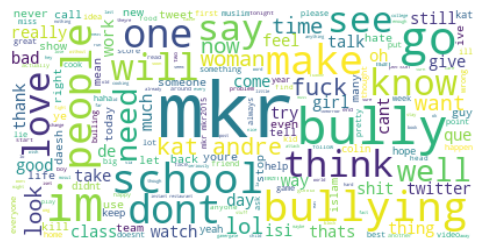

In [158]:
make_wordcloud(df_no)

### Wordcloud for Religion Cyberbully





/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


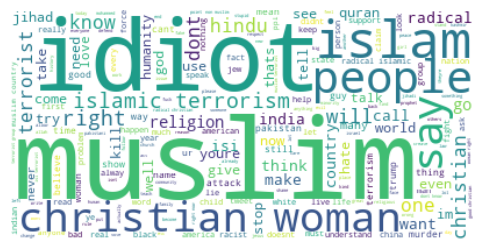

In [159]:
make_wordcloud(df_religion)

### Wordcloud for Ethnicity Cyberbully

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


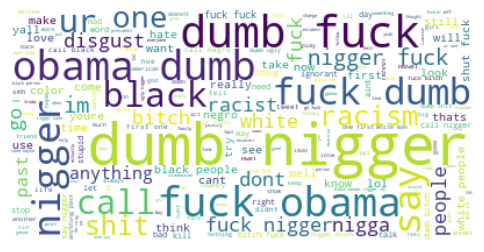

In [160]:
make_wordcloud(df_ethnicity)

### Wordcloud for Gender Cyberbully

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


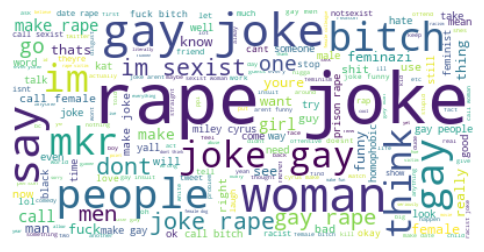

In [161]:
make_wordcloud(df_gender)

### Wordcloud for Age Cyberbully

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


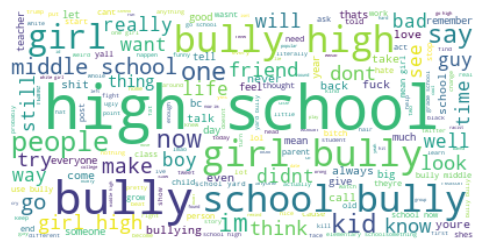

In [162]:
make_wordcloud(df_age)

### Wordcloud for Other Cyberbully

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


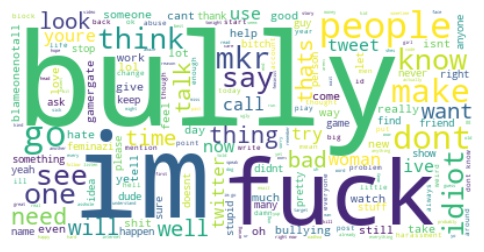

In [163]:
make_wordcloud(df_other)

## Training - Evaluate Model

For the multiclass classification, we'll one-hot the target label before splitting them

In [164]:
X = df_prep_e['sentence_lemmatized']
y = df_prep_e['cyberbullying_type']
y = pd.get_dummies(df_prep_e['cyberbullying_type']).values
print(pd.get_dummies(df_prep_e['cyberbullying_type']))

       age  ethnicity  gender  not_cyberbullying  other_cyberbullying  religion
0        0          0       0                  1                    0         0
1        0          0       0                  1                    0         0
2        0          0       0                  1                    0         0
3        0          0       0                  1                    0         0
4        0          0       0                  1                    0         0
...    ...        ...     ...                ...                  ...       ...
47687    0          1       0                  0                    0         0
47688    0          1       0                  0                    0         0
47689    0          1       0                  0                    0         0
47690    0          1       0                  0                    0         0
47691    0          1       0                  0                    0         0

[47436 rows x 6 columns]


The label legend is based on the alphabetic order:
0. Age
1. Ethnicity
2. Gender
3. Not_Cyberbullying
4. Other_Cyberbullying
5. Religion

In [165]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, 
                                                    random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, 
                                                    test_size=0.10, 
                                                    random_state=42)

We'll use Tokenizer as tools to tokenize all the words. The padding is set to 30 in considering the 280 characters limit on twitter

In [166]:
max_length = 30
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
validation_sequences = tokenizer.texts_to_sequences(X_valid)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding='post', truncating='post')

In [167]:
len(tokenizer.word_index)

34598

In [168]:
print(train_padded.shape,y_train.shape)
print(validation_padded.shape,y_valid.shape)

(34153, 30) (34153, 6)
(3795, 30) (3795, 6)


### LSTM

First we'll try using LSTM

In [169]:
modelLSTM = Sequential()
modelLSTM.add(Embedding(max_words, max_length, input_length=train_padded.shape[1]))
modelLSTM.add(LSTM(128, dropout = 0.2))
modelLSTM.add(Dense(32, activation = 'relu'))
modelLSTM.add(Dense(6, activation='softmax'))
modelLSTM.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

epochs = 100
batch_size = 32

history = modelLSTM.fit(train_padded, y_train, validation_data=(validation_padded, y_valid), epochs=epochs, batch_size=batch_size, callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))


Epoch 1/100
1068/1068 [==============================] - 15s 12ms/step - loss: 1.7795 - accuracy: 0.2225 - val_loss: 1.7529 - val_accuracy: 0.2899
Epoch 2/100
1068/1068 [==============================] - 13s 12ms/step - loss: 1.6625 - accuracy: 0.2781 - val_loss: 1.6097 - val_accuracy: 0.3004
Epoch 3/100
1068/1068 [==============================] - 13s 12ms/step - loss: 1.5987 - accuracy: 0.2872 - val_loss: 1.5916 - val_accuracy: 0.2928
Epoch 4/100
1068/1068 [==============================] - 14s 13ms/step - loss: 1.5901 - accuracy: 0.2869 - val_loss: 1.5863 - val_accuracy: 0.2814
Epoch 5/100
1068/1068 [==============================] - 16s 15ms/step - loss: 1.5808 - accuracy: 0.2863 - val_loss: 1.5763 - val_accuracy: 0.2822
Epoch 6/100
1068/1068 [==============================] - 14s 13ms/step - loss: 1.5412 - accuracy: 0.3008 - val_loss: 1.5573 - val_accuracy: 0.3038
Epoch 7/100
1068/1068 [==============================] - 15s 14ms/step - loss: 1.3769 - accuracy: 0.3842 - val_loss: 1

In [170]:
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

For the classification report reference:

0: Age 1: Ethnicity

2: Gender 3: Not_Cyberbullying

4: Other_Cyberbullying 5: Religion

In [171]:
y_pred = modelLSTM.predict(test_padded)
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94      1540
           1       0.96      0.95      0.96      1612
           2       0.94      0.70      0.80      1509
           3       0.52      0.47      0.49      1604
           4       0.55      0.71      0.62      1617
           5       0.90      0.94      0.92      1606

    accuracy                           0.79      9488
   macro avg       0.80      0.79      0.79      9488
weighted avg       0.80      0.79      0.79      9488



The f1-weighted average scores nicely in 0.79. The model seems to struggle in correctly predicting the non-cyberbullying (Label 3). But since we focus on classifying the cyberbullying one, it's still fine--we aren't simply classifying all tweet as cyberbullying then prevent people from tweeting anything

### GRU

In [172]:
modelGRU = Sequential()
modelGRU.add(Embedding(max_words, max_length, input_length=train_padded.shape[1]))
modelGRU.add(GRU(128, dropout = 0.2))
modelGRU.add(Dense(32, activation = 'relu'))
modelGRU.add(Dense(6, activation='softmax'))
modelGRU.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

epochs = 100
batch_size = 32

history = modelGRU.fit(train_padded, y_train, validation_data=(validation_padded, y_valid), epochs=epochs, batch_size=batch_size, callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))

Epoch 1/100
1068/1068 [==============================] - 15s 12ms/step - loss: 1.7621 - accuracy: 0.2455 - val_loss: 1.7051 - val_accuracy: 0.2501
Epoch 2/100
1068/1068 [==============================] - 12s 11ms/step - loss: 1.6510 - accuracy: 0.2651 - val_loss: 1.6172 - val_accuracy: 0.2701
Epoch 3/100
1068/1068 [==============================] - 12s 11ms/step - loss: 1.6157 - accuracy: 0.2785 - val_loss: 1.6016 - val_accuracy: 0.2796
Epoch 4/100
1068/1068 [==============================] - 12s 11ms/step - loss: 1.6041 - accuracy: 0.2848 - val_loss: 1.5922 - val_accuracy: 0.2856
Epoch 5/100
1068/1068 [==============================] - 12s 12ms/step - loss: 1.5996 - accuracy: 0.2875 - val_loss: 1.5903 - val_accuracy: 0.2772
Epoch 6/100
1068/1068 [==============================] - 12s 11ms/step - loss: 1.5950 - accuracy: 0.2864 - val_loss: 1.5891 - val_accuracy: 0.2854
Epoch 7/100
1068/1068 [==============================] - 14s 13ms/step - loss: 1.5912 - accuracy: 0.2883 - val_loss: 1

In [173]:
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

For the classification report reference:

0: Age 1: Ethnicity

2: Gender 3: Not_Cyberbullying

4: Other_Cyberbullying 5: Religion

In [174]:
y_pred = modelGRU.predict(test_padded)
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.93      0.94      0.94      1540
           1       0.94      0.95      0.94      1612
           2       0.91      0.75      0.82      1509
           3       0.55      0.39      0.46      1604
           4       0.54      0.70      0.61      1617
           5       0.84      0.95      0.89      1606

    accuracy                           0.78      9488
   macro avg       0.78      0.78      0.78      9488
weighted avg       0.78      0.78      0.77      9488



The f1-weighted average scores in 0.77, slightly lower than LSTM. This model also struggle in correctly predicting the non-cyberbullying (Label 3)

## Training - Evaluate Model: Binary Class

We'll try to simplify the case to binary classification to see how the model will perform (with 0 being not flagged / not-cyberbully and 1 being flagged / cyberbully)

### LSTM

In [175]:
X = df_prep_e['sentence_lemmatized']
y_bin = df_prep_e['cyberbullying_type']
y_bin = y_bin.replace('age', 1)
y_bin = y_bin.replace('ethnicity', 1)
y_bin = y_bin.replace('religion', 1)
y_bin = y_bin.replace('gender', 1)
y_bin = y_bin.replace('other_cyberbullying', 1)
y_bin = y_bin.replace('not_cyberbullying', 0)

In [176]:
X_train, X_test, y_train_bin, y_test_bin = train_test_split(X, y_bin, 
                                                    test_size=0.20, 
                                                    random_state=42)
X_train, X_valid, y_train_bin, y_valid_bin = train_test_split(X_train, y_train_bin, 
                                                    test_size=0.10, 
                                                    random_state=42)

In [177]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
validation_sequences = tokenizer.texts_to_sequences(X_valid)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding='post', truncating='post')

In [180]:
modelLSTMBin = Sequential()
modelLSTMBin.add(Embedding(max_words, max_length, input_length=train_padded.shape[1]))
modelLSTMBin.add(LSTM(128, dropout = 0.2))
modelLSTMBin.add(Dense(32))
modelLSTMBin.add(Dense(1, activation='sigmoid'))
modelLSTMBin.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 100
batch_size = 32

history = modelLSTMBin.fit(train_padded, y_train_bin, validation_data=(validation_padded, y_valid_bin), epochs=epochs, batch_size=batch_size, callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))

Epoch 1/100
1068/1068 [==============================] - 22s 16ms/step - loss: 0.3024 - accuracy: 0.8508 - val_loss: 0.2603 - val_accuracy: 0.8722
Epoch 2/100
1068/1068 [==============================] - 18s 16ms/step - loss: 0.2377 - accuracy: 0.8815 - val_loss: 0.2619 - val_accuracy: 0.8727
Epoch 3/100
1068/1068 [==============================] - 17s 16ms/step - loss: 0.2117 - accuracy: 0.8965 - val_loss: 0.2720 - val_accuracy: 0.8627
Epoch 4/100
1068/1068 [==============================] - 14s 13ms/step - loss: 0.1891 - accuracy: 0.9063 - val_loss: 0.3325 - val_accuracy: 0.8630
Epoch 5/100
1068/1068 [==============================] - 14s 13ms/step - loss: 0.1723 - accuracy: 0.9167 - val_loss: 0.3439 - val_accuracy: 0.8538
Epoch 6/100
1068/1068 [==============================] - 14s 13ms/step - loss: 0.1593 - accuracy: 0.9214 - val_loss: 0.4022 - val_accuracy: 0.8646


The model stopped so early (in 6th epoch), meaning there's not much to improve here

In [181]:
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

In [182]:
y_pred = modelLSTMBin.predict(test_padded)
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1
print(classification_report(y_test_bin,y_pred))

              precision    recall  f1-score   support

           0       0.71      0.29      0.41      1604
           1       0.87      0.98      0.92      7884

    accuracy                           0.86      9488
   macro avg       0.79      0.63      0.67      9488
weighted avg       0.84      0.86      0.84      9488



The F1-weighted average here is 0.84, which is good. But again, we saw the poor performance in classifying the non-cyberbullying tweet

### GRU

In [184]:
modelGRUBin = Sequential()
modelGRUBin.add(Embedding(max_words, max_length, input_length=train_padded.shape[1]))
modelGRUBin.add(GRU(128, dropout = 0.2))
modelGRUBin.add(Dense(32, activation='relu'))
modelGRUBin.add(Dense(1, activation='sigmoid'))
modelGRUBin.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 100
batch_size = 32

history = modelGRUBin.fit(train_padded, y_train_bin, validation_data=(validation_padded, y_valid_bin), epochs=epochs, batch_size=batch_size, callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))


Epoch 1/100
1068/1068 [==============================] - 49s 13ms/step - loss: 0.3086 - accuracy: 0.8444 - val_loss: 0.2644 - val_accuracy: 0.8646
Epoch 2/100
1068/1068 [==============================] - 13s 13ms/step - loss: 0.2398 - accuracy: 0.8761 - val_loss: 0.2564 - val_accuracy: 0.8711
Epoch 3/100
1068/1068 [==============================] - 14s 13ms/step - loss: 0.2081 - accuracy: 0.8961 - val_loss: 0.2699 - val_accuracy: 0.8693
Epoch 4/100
1068/1068 [==============================] - 14s 13ms/step - loss: 0.1867 - accuracy: 0.9079 - val_loss: 0.2977 - val_accuracy: 0.8627
Epoch 5/100
1068/1068 [==============================] - 14s 13ms/step - loss: 0.1678 - accuracy: 0.9176 - val_loss: 0.3545 - val_accuracy: 0.8682
Epoch 6/100
1068/1068 [==============================] - 14s 13ms/step - loss: 0.1535 - accuracy: 0.9255 - val_loss: 0.3310 - val_accuracy: 0.8627
Epoch 7/100
1068/1068 [==============================] - 14s 13ms/step - loss: 0.1413 - accuracy: 0.9296 - val_loss: 0

In [185]:
y_pred = modelGRUBin.predict(test_padded)
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1
print(classification_report(y_test_bin,y_pred))

              precision    recall  f1-score   support

           0       0.55      0.52      0.53      1604
           1       0.90      0.91      0.91      7884

    accuracy                           0.85      9488
   macro avg       0.72      0.72      0.72      9488
weighted avg       0.84      0.85      0.84      9488



We saw the same result here, 0.84 on F1-weighted average score and poor performance on classifying the non-cyberbullying tweets

## Model Inference

Suppose we are having these sentences, will the model flag these? 

In [230]:
infer_text_1 = "Good luck on your thesis!!!!!! XOXO"
infer_text_2 = "You rotten son of a bitch gtfo"
infer_text_3 = "Man, that's fucking crazy. Whatever you do, you fucking have to survive, you hear? :("
infer_text_4 = "Everyone just love to misquote Nietzsche God is Dead stuff huh?"
infer_text_5 = "LMAO "

In [251]:
def cyberbullying_prediction(text):
  print("Original: ", text)
  text = clean_text_r1(text)
  text = clear_text_r2_with_emoji(text)
  text = tweet_tokenize(text)
  text = lemmatize_pos(text)
  text = join_lemmatize_sentence(text)
  text = [text]
  infer_seq = tokenizer.texts_to_sequences(text)
  infer_pad = pad_sequences(infer_seq, maxlen=max_length, padding='post', truncating = 'post')
  y_predbin = modelGRUBin.predict(infer_pad) #GRU is chosen because balanced precision-recall
  if y_predbin <= 0.5:
    print('This tweet is safe!')
  else:
    print('This tweet is flagged as cyberbullying')
  y_pred = modelLSTM.predict(infer_pad) #LSTM is chosen because overall F1-weighted average is better
  y_pred = np.argmax(y_pred, axis=1)
  if y_pred == 0:
    print('This tweet is considered cyberbullying related to age')
  elif y_pred == 1:
    print('This tweet is considered cyberbullying related to ethnicity')
  elif y_pred == 2:
    print('This tweet is considered cyberbullying related to gender')
  elif y_pred == 3:
    print('This tweet is not considered as cyberbullying')
  elif y_pred == 4:
    print('This tweet is considered cyberbullying other than mentioned category.')
  elif y_pred == 5:
    print('This tweet is considered cyberbullying related to religion')

In [252]:
cyberbullying_prediction(infer_text_1)

Original:  Good luck on your thesis!!!!!! XOXO
This tweet is flagged as cyberbullying
This tweet is considered cyberbullying other than mentioned category.


In [253]:
cyberbullying_prediction(infer_text_2)

Original:  You rotten son of a bitch gtfo
This tweet is flagged as cyberbullying
This tweet is not considered as cyberbullying


In [254]:
cyberbullying_prediction(infer_text_3)

Original:  Man, that's fucking crazy. Whatever you do, you fucking have to survive, you hear? :(
This tweet is flagged as cyberbullying
This tweet is considered cyberbullying other than mentioned category.


In [255]:
cyberbullying_prediction(infer_text_4)

Original:  Everyone just love to misquote Nietzsche God is Dead stuff huh?
This tweet is safe!
This tweet is considered cyberbullying other than mentioned category.


In [256]:
cyberbullying_prediction(infer_text_5)

Original:  LMAO 
This tweet is flagged as cyberbullying
This tweet is not considered as cyberbullying


On the 4th sentence, the binary and multiclass classification conflicted, as the binary marked it safe and the multiclass flagged it as "other" cyberbullying 

## General Conclusion

1. The wordcloud visualization shows that there are indeed some words that were used frequently in some cyberbullying category, such as mentioning ethnicity (explicitly saying the word nigger, or mentioning Obama directly)

2. The result of the model LSTM perform slightly better than GRU in multiclass classification, with F1-weighted average of 0.79 compared to 0.77. The result of the binary class (non-flagged vs flagged) on the other hand, is showing the same result in F1-weighted average (0.84)

3. Classification of non-cyberbullying is shown to be poor in both of the multiclass-classification and binary classification. While this might simply be data imbalance, other possible explanation is that non-cyberbullying category is 'wide' in topic, while other cyberbullying are more 'focused' (meaning that the word pool is smaller).